# Motivation

### End users:
Marketing and Customer Service Employees of Telecommunication companys

### Goal of end users:
In order to maximize customer retention it is important to detect which customers will possible cancel their subscription in the near future. By identifying those customer through certain indicators actions can be made to prevent the loss of the customer.

### Obstacle to be solved:
Generate a model which can prediction if a customer will cancel their subscription in the near future based on certain CRM-Data



# Data Collection and preparation

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
print(sklearn.__version__)

1.4.1.post1


In [4]:
# Datenimport
churn_df = pd.read_csv('churn80.csv', delimiter=',')
income_df = pd.read_csv('income_data.csv', delimiter=';')

# Daten-Merging
merged_df = pd.merge(churn_df, income_df, on='State')

# Kategorische Variablen umwandeln (Yes/No zu 1/0)
binary_columns = ['International plan', 'Voice mail plan', 'Churn']
for col in binary_columns:
    merged_df[col] = merged_df[col].map({'Yes': 1, 'No': 0, True: 1, False: 0})

print(merged_df.iloc[0])


State                        KS
Account length              128
Area code                   415
International plan            0
Voice mail plan               1
Number vmail messages        25
Total day minutes         265.1
Total day calls             110
Total day charge          45.07
Total eve minutes         197.4
Total eve calls              99
Total eve charge          16.78
Total night minutes       244.7
Total night calls            91
Total night charge        11.01
Total intl minutes         10.0
Total intl calls              3
Total intl charge           2.7
Customer service calls        1
Churn                         0
mean_income               43730
unemployment                2.8
Name: 0, dtype: object


In [5]:
merged_df.dropna(inplace=True)

merged_df.drop_duplicates(inplace=True)

print(merged_df.isnull().sum())
print(f"Anzahl der verbleibenden Zeilen nach der Bereinigung: {merged_df.shape[0]}")

State                     0
Account length            0
Area code                 0
International plan        0
Voice mail plan           0
Number vmail messages     0
Total day minutes         0
Total day calls           0
Total day charge          0
Total eve minutes         0
Total eve calls           0
Total eve charge          0
Total night minutes       0
Total night calls         0
Total night charge        0
Total intl minutes        0
Total intl calls          0
Total intl charge         0
Customer service calls    0
Churn                     0
mean_income               0
unemployment              0
dtype: int64
Anzahl der verbleibenden Zeilen nach der Bereinigung: 2666


## Feature Engineering

In [6]:
# Nutzungskonsistenz
merged_df['usage_variance'] = merged_df[['Total day minutes', 'Total eve minutes', 'Total night minutes']].var(axis=1)

# Gesamtanrufdauer
merged_df['total_call_duration'] = merged_df['Total day minutes'] + merged_df['Total eve minutes'] + merged_df['Total night minutes'] + merged_df['Total intl minutes']

# Durchschnittliche Anrufdauer
merged_df['avg_call_duration'] = merged_df['total_call_duration'] / (merged_df['Total day calls'] + merged_df['Total eve calls'] + merged_df['Total night calls'] + merged_df['Total intl calls'])

# Interaktionshäufigkeit mit dem Kundendienst
merged_df['service_call_frequency'] = merged_df['Customer service calls'] / merged_df['Account length']

# Berechnung der gesamten Anrufkosten
merged_df['total_call_charge'] = merged_df['Total day charge'] + merged_df['Total eve charge'] + merged_df['Total night charge'] + merged_df['Total intl charge']

# Kosten pro Minute
merged_df['cost_per_minute'] = merged_df['total_call_charge'] / merged_df['total_call_duration']

print(merged_df.iloc[0])

State                              KS
Account length                    128
Area code                         415
International plan                  0
Voice mail plan                     1
Number vmail messages              25
Total day minutes               265.1
Total day calls                   110
Total day charge                45.07
Total eve minutes               197.4
Total eve calls                    99
Total eve charge                16.78
Total night minutes             244.7
Total night calls                  91
Total night charge              11.01
Total intl minutes               10.0
Total intl calls                    3
Total intl charge                 2.7
Customer service calls              1
Churn                               0
mean_income                     43730
unemployment                      2.8
usage_variance            1206.123333
total_call_duration             717.2
avg_call_duration            2.366997
service_call_frequency       0.007812
total_call_c

## EDA

       Account length    Area code  International plan  Voice mail plan  \
count     2666.000000  2666.000000         2666.000000      2666.000000   
mean       100.620405   437.438860            0.101275         0.274944   
std         39.563974    42.521018            0.301750         0.446570   
min          1.000000   408.000000            0.000000         0.000000   
25%         73.000000   408.000000            0.000000         0.000000   
50%        100.000000   415.000000            0.000000         0.000000   
75%        127.000000   510.000000            0.000000         1.000000   
max        243.000000   510.000000            1.000000         1.000000   

       Number vmail messages  Total day minutes  Total day calls  \
count            2666.000000         2666.00000      2666.000000   
mean                8.021755          179.48162       100.310203   
std                13.612277           54.21035        19.988162   
min                 0.000000            0.00000     

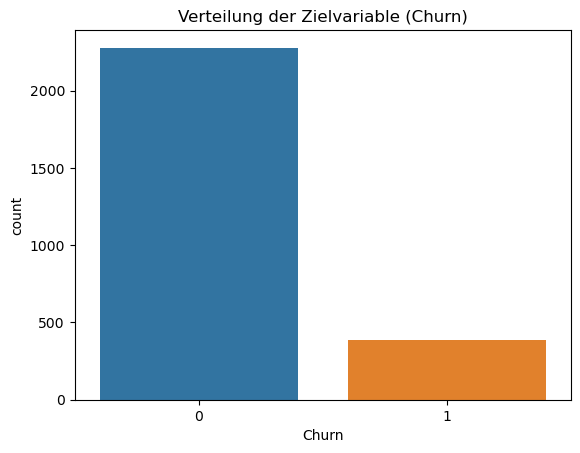

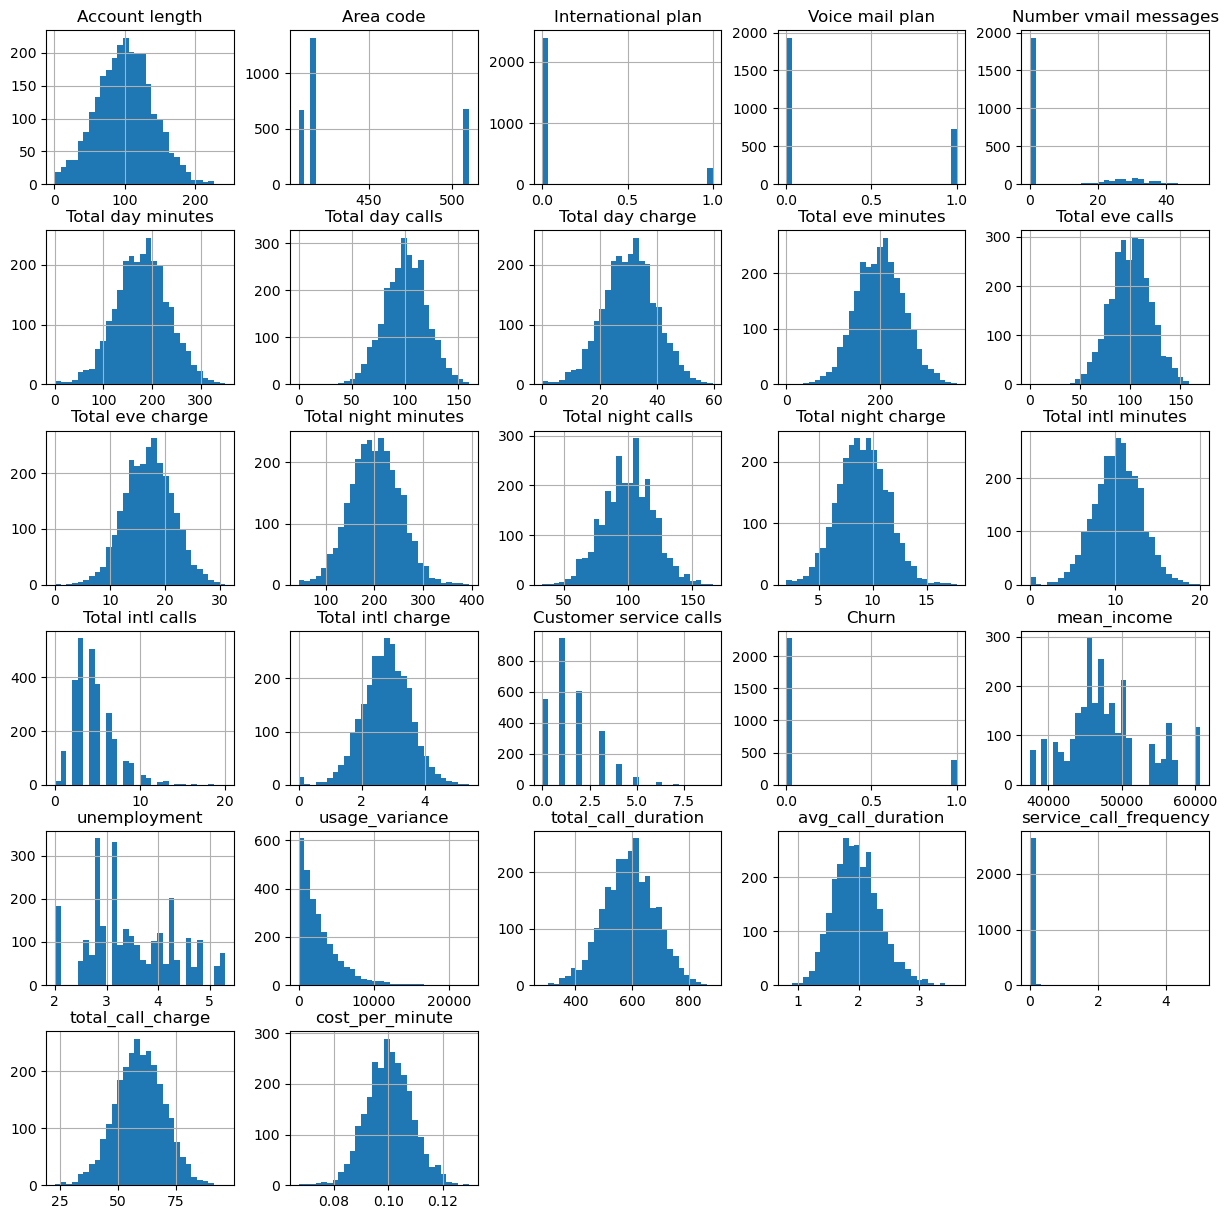

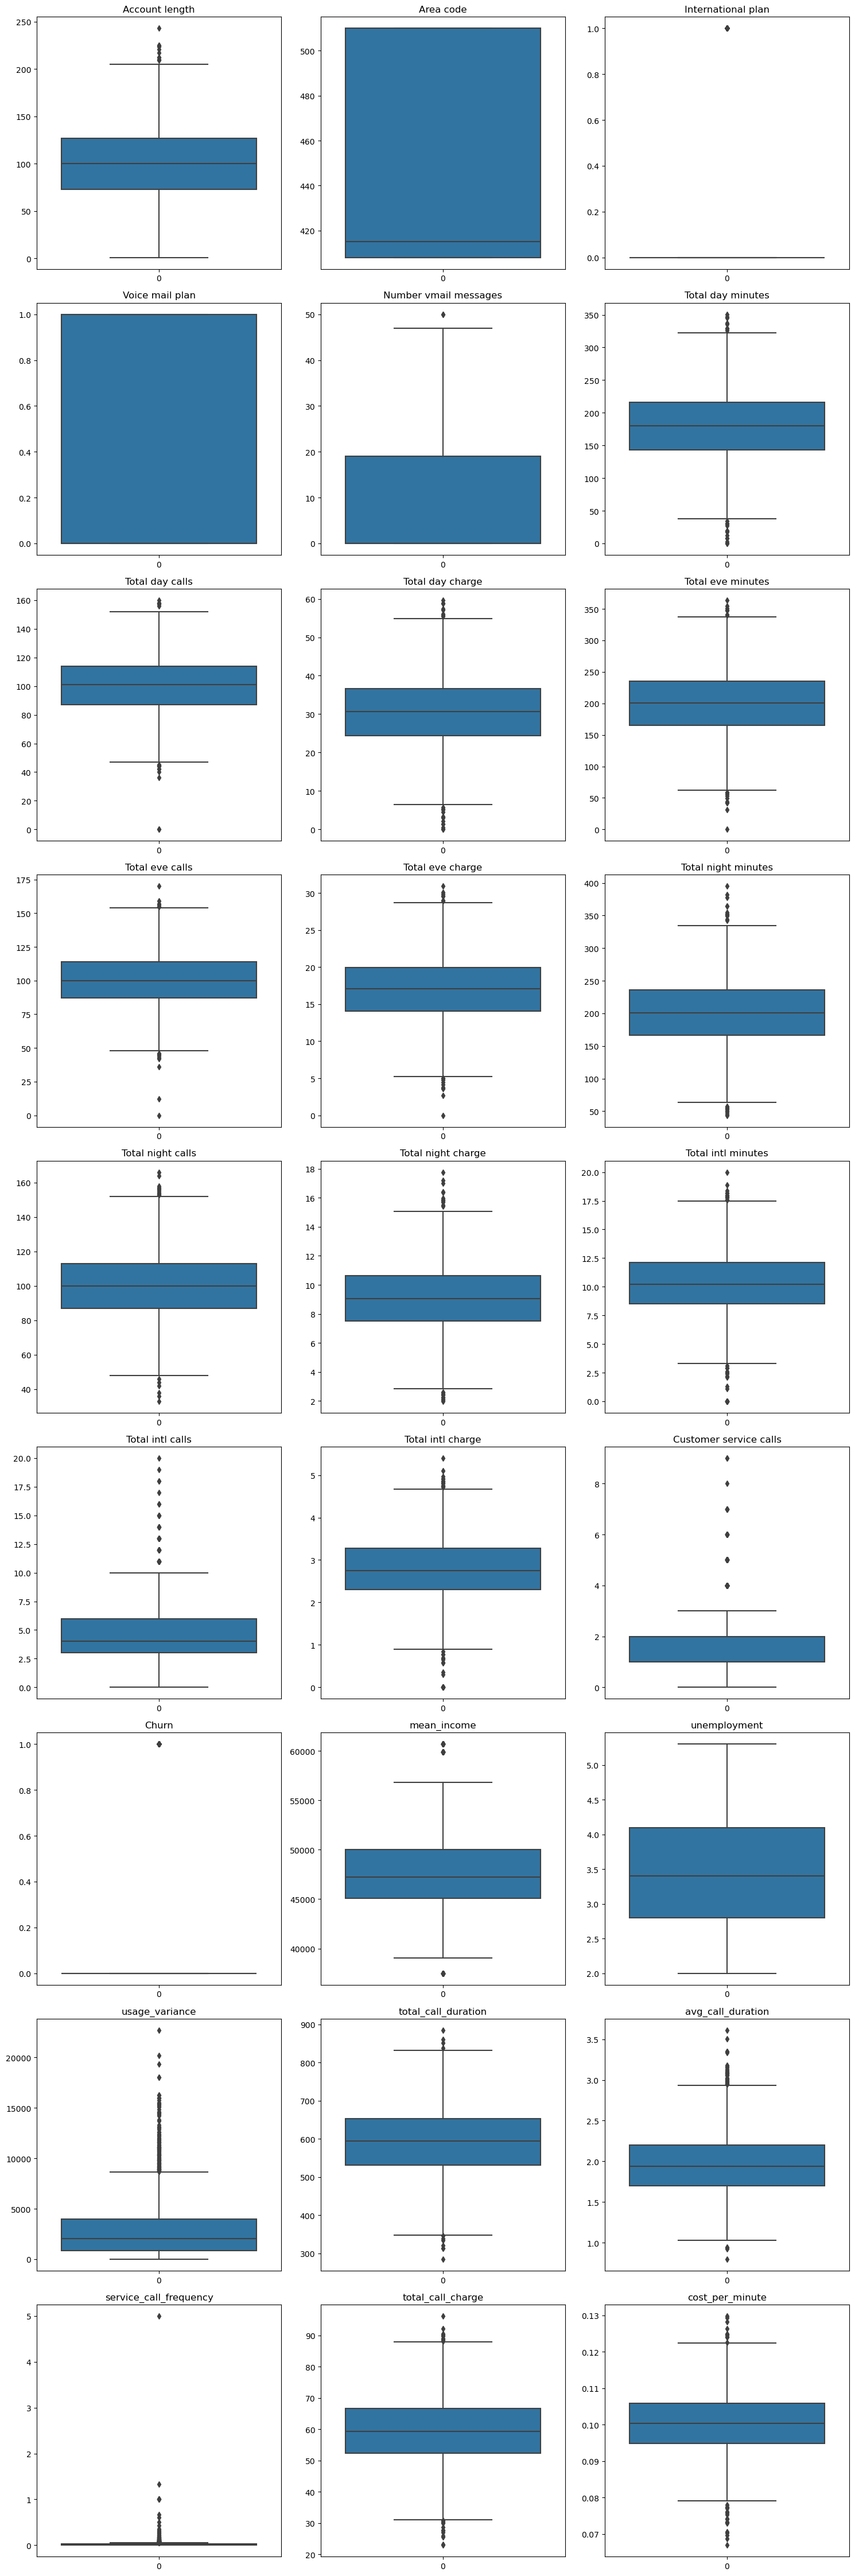

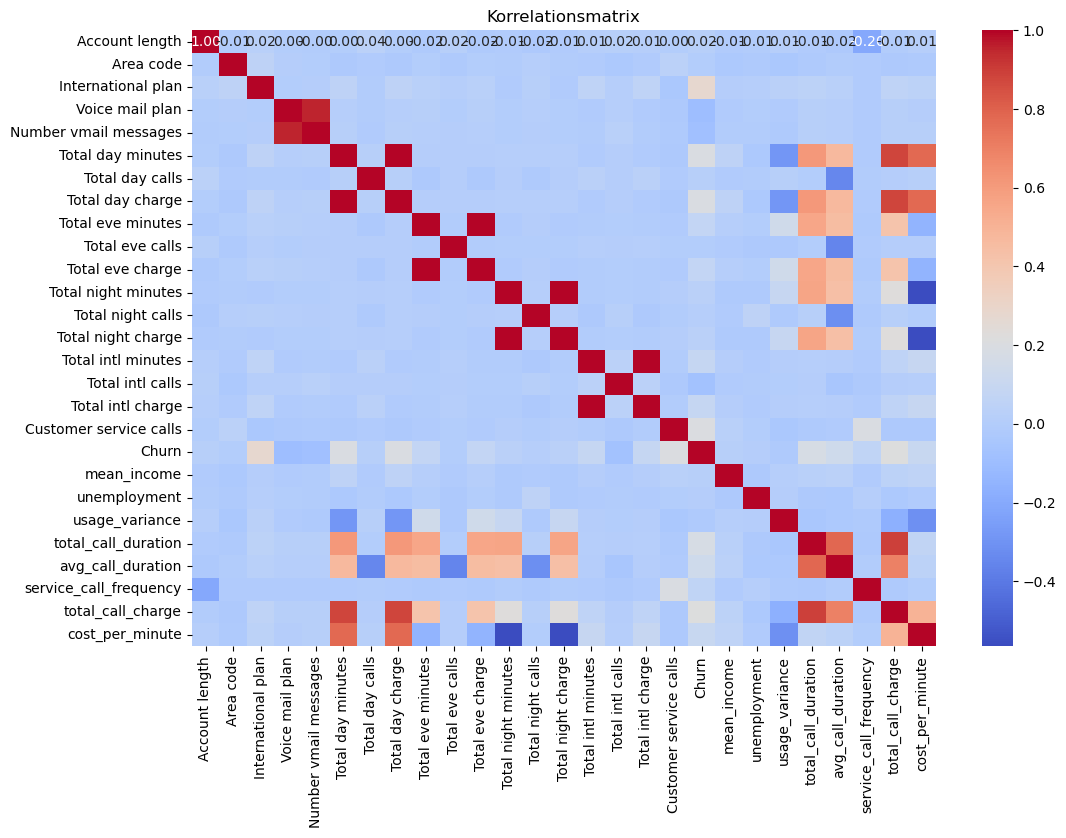

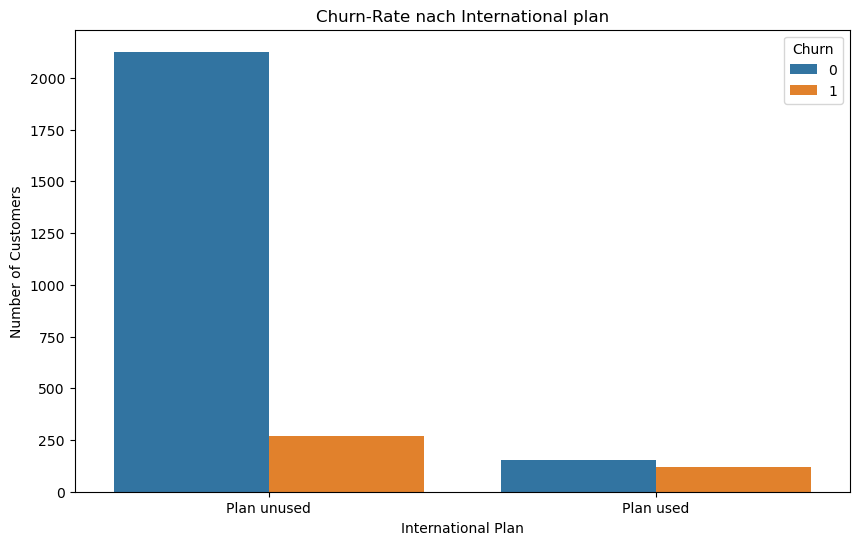

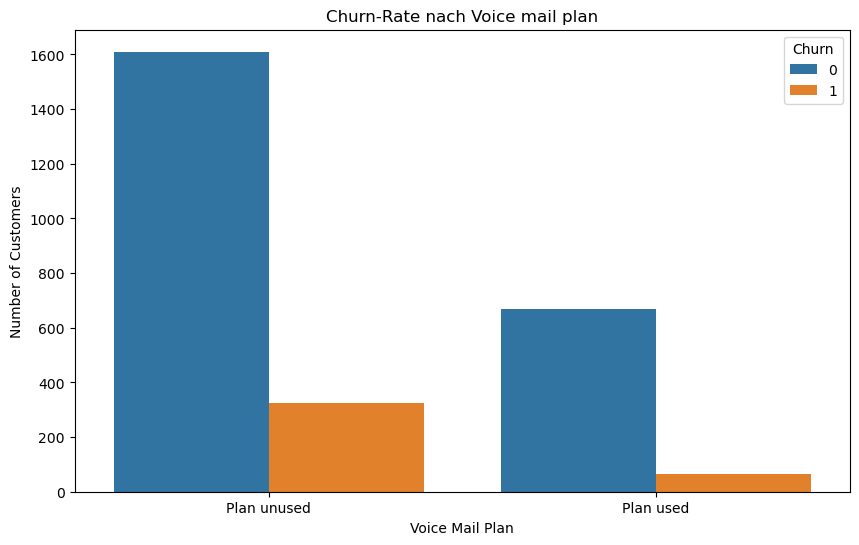

In [7]:
# Explorative Datenanalyse (EDA)
# Grundlegende Statistiken
print(merged_df.describe())

# Verteilung der Zielvariable
sns.countplot(x='Churn', data=merged_df)
plt.title('Verteilung der Zielvariable (Churn)')
plt.show()

# Histogramme für numerische Merkmale
merged_df.hist(bins=30, figsize=(15, 15))
plt.show()

# Boxplots zur Identifizierung von Ausreißern
numeric_data = merged_df.select_dtypes(include=[np.number])

# Anzahl der Merkmale
num_columns = numeric_data.shape[1]

# Festlegen der Anzahl der Merkmale pro Zeile
cols_per_row = 3

# Berechnung der Anzahl der Zeilen
num_rows = (num_columns // cols_per_row) + int(num_columns % cols_per_row > 0)

# Erstellen der Subplots
fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(15, num_rows * 5))

# Flatten der Achsen für einfache Iteration
axes = axes.flatten()

# Plotten der Boxplots
for i, col in enumerate(numeric_data.columns):
    sns.boxplot(data=numeric_data[col], ax=axes[i])
    axes[i].set_title(col)

# Entfernen der leeren Subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Layout anpassen und anzeigen
plt.tight_layout()
plt.show()

# Korrelationsmatrix nur für numerische Spalten
numerical_cols = merged_df.select_dtypes(include=[np.number])
plt.figure(figsize=(12, 8))
sns.heatmap(numerical_cols.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Korrelationsmatrix')
plt.show()


# Churn-Rate nach International plan
plt.figure(figsize=(10, 6))
sns.countplot(x='International plan', hue='Churn', data=merged_df)
plt.title('Churn-Rate nach International plan')
plt.xticks(ticks=[0, 1], labels=['Plan unused', 'Plan used'])
plt.xlabel('International Plan')
plt.ylabel('Number of Customers')
plt.show()

# Churn-Rate nach Voice mail plan
plt.figure(figsize=(10, 6))
sns.countplot(x='Voice mail plan', hue='Churn', data=merged_df)
plt.title('Churn-Rate nach Voice mail plan')
plt.xticks(ticks=[0, 1], labels=['Plan unused', 'Plan used'])
plt.xlabel('Voice Mail Plan')
plt.ylabel('Number of Customers')
plt.show()

Anzahl der Ausreißer: 210


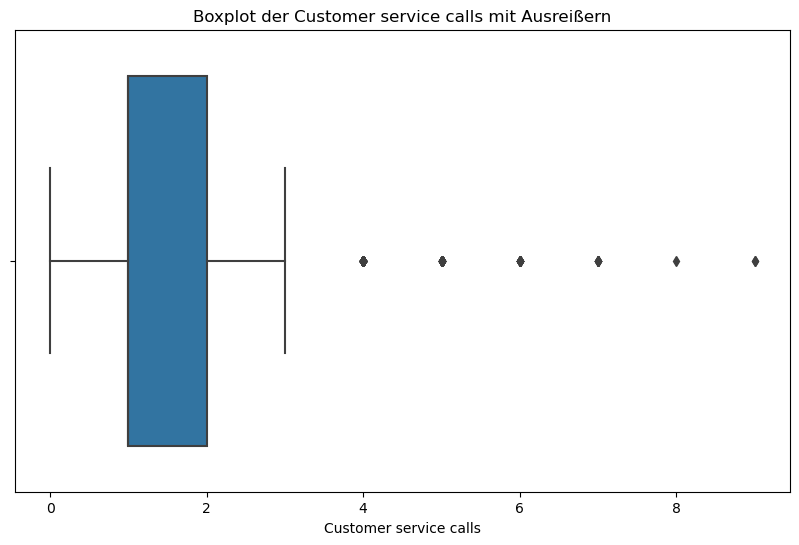

In [8]:
# Berechnung des IQR (Interquartilsabstand)
Q1 = merged_df['Customer service calls'].quantile(0.25)
Q3 = merged_df['Customer service calls'].quantile(0.75)
IQR = Q3 - Q1

# Definition von Grenzen für Ausreißer
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identifikation von Ausreißern
outliers = merged_df[(merged_df['Customer service calls'] < lower_bound) | (merged_df['Customer service calls'] > upper_bound)]
print(f"Anzahl der Ausreißer: {outliers.shape[0]}")

# Visualisierung der Ausreißer
plt.figure(figsize=(10, 6))
sns.boxplot(x=merged_df['Customer service calls'])
plt.title('Boxplot der Customer service calls mit Ausreißern')
plt.show()


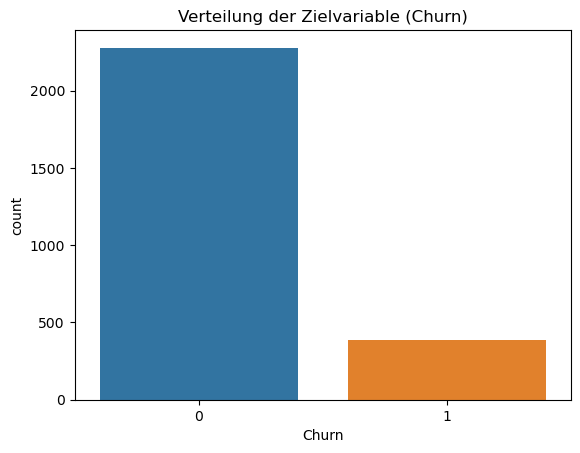

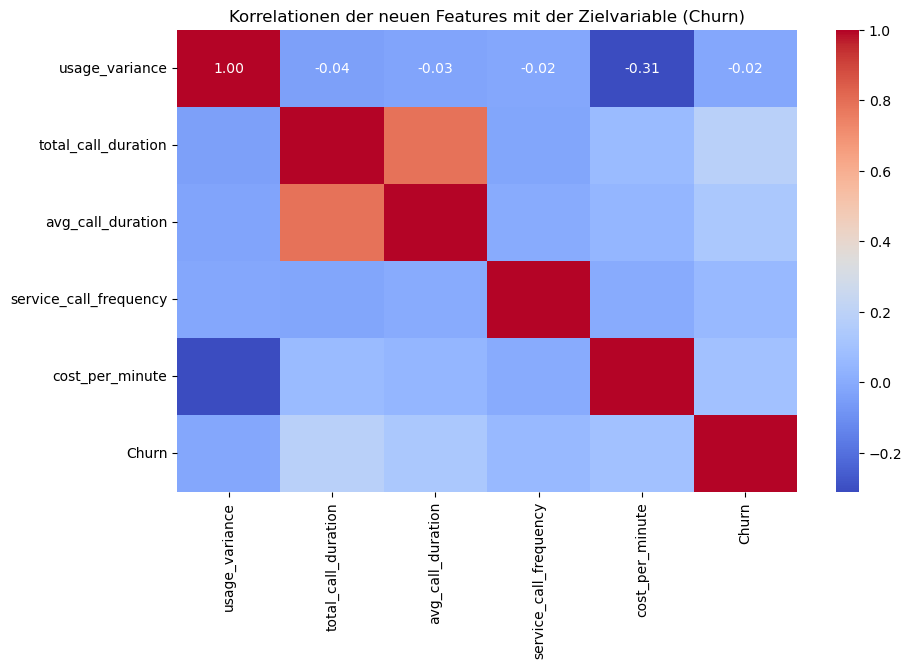

c:\Users\dario\anaconda3\envs\kia\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\dario\anaconda3\envs\kia\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\dario\anaconda3\envs\kia\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\dario\anaconda3\envs\kia\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-

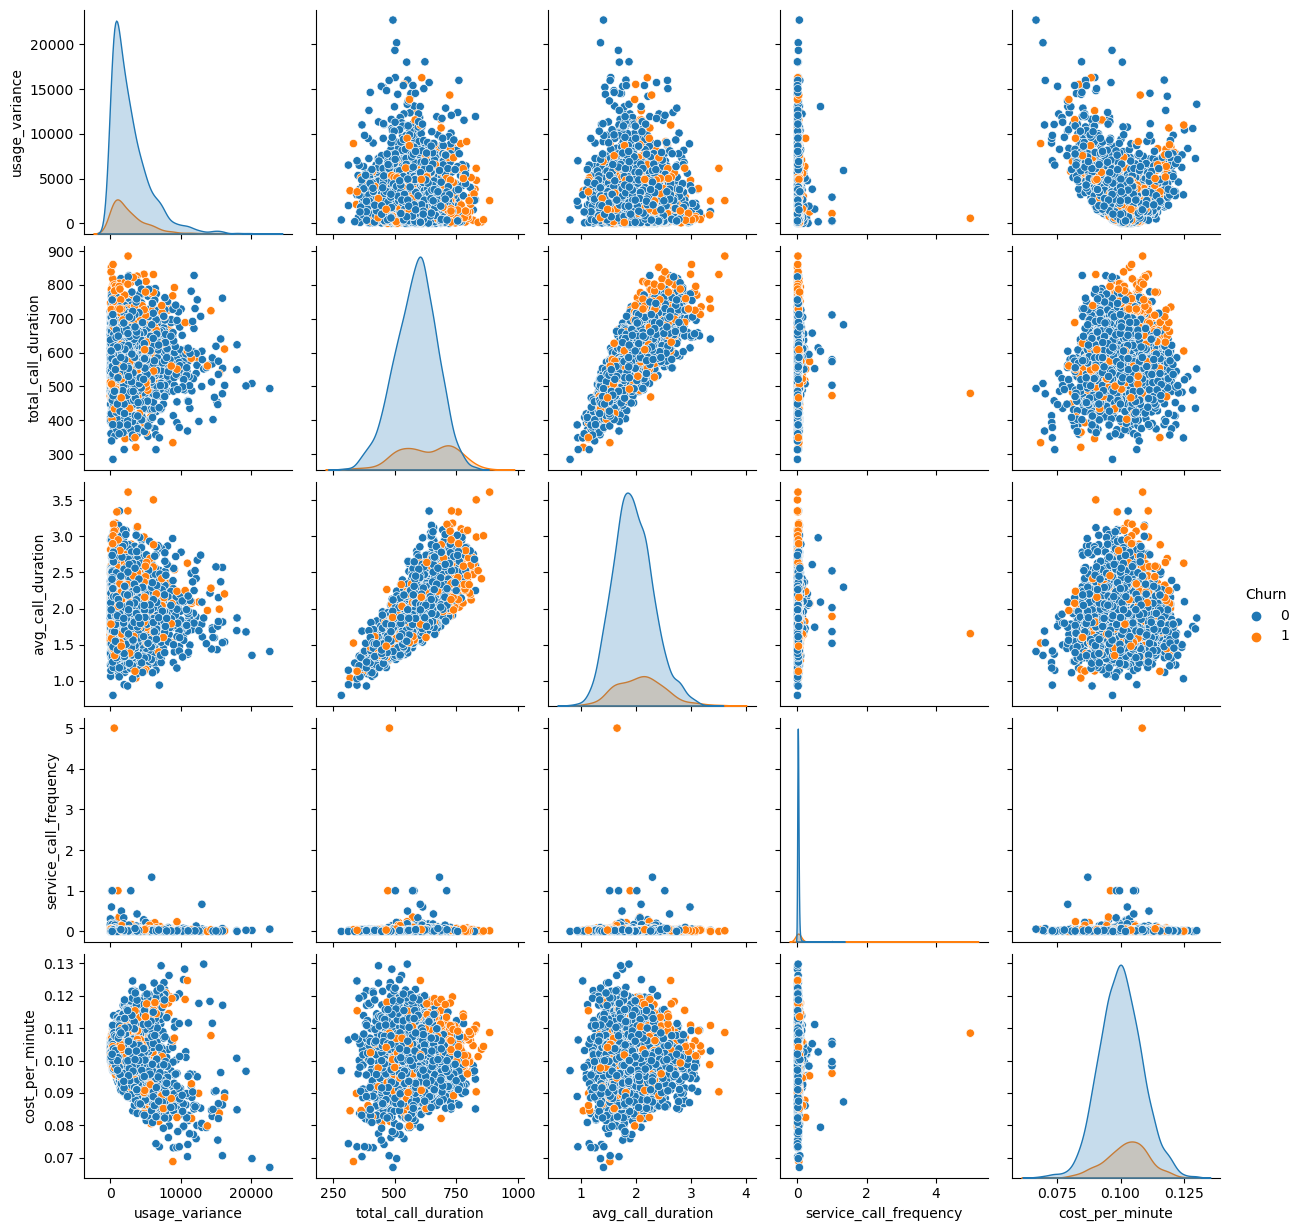

In [9]:
# Verteilung der Zielvariable
sns.countplot(x='Churn', data=merged_df)
plt.title('Verteilung der Zielvariable (Churn)')
plt.show()

# Korrelationen der neuen Features mit der Zielvariable Churn
correlation_features = ['usage_variance', 'total_call_duration', 'avg_call_duration', 'service_call_frequency', 'cost_per_minute', 'Churn']
correlation_matrix = merged_df[correlation_features].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Korrelationen der neuen Features mit der Zielvariable (Churn)')
plt.show()

# Paarweise Beziehungen zwischen den neuen Features und der Zielvariable
sns.pairplot(merged_df[correlation_features], hue='Churn')
plt.show()

# Model Training

In [10]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

In [11]:
# Feature- und Zielvariablen
X = merged_df.drop(['Churn', 'State'], axis=1)
y = merged_df['Churn']

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

c:\Users\dario\anaconda3\envs\kia\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\dario\anaconda3\envs\kia\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

Logistic Regression Cross-Validation Accuracy: 0.8560
Logistic Regression Cross-Validation Precision: 0.5274
Logistic Regression Cross-Validation Recall: 0.0875
Logistic Regression Cross-Validation F1 Score: 0.1488

Logistic Regression Test Accuracy: 0.8558
Logistic Regression Test Precision: 0.5714
Logistic Regression Test Recall: 0.1013
Logistic Regression Test F1 Score: 0.1720
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       455
           1       0.57      0.10      0.17        79

    accuracy                           0.86       534
   macro avg       0.72      0.54      0.55       534
weighted avg       0.82      0.86      0.81       534



c:\Users\dario\anaconda3\envs\kia\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


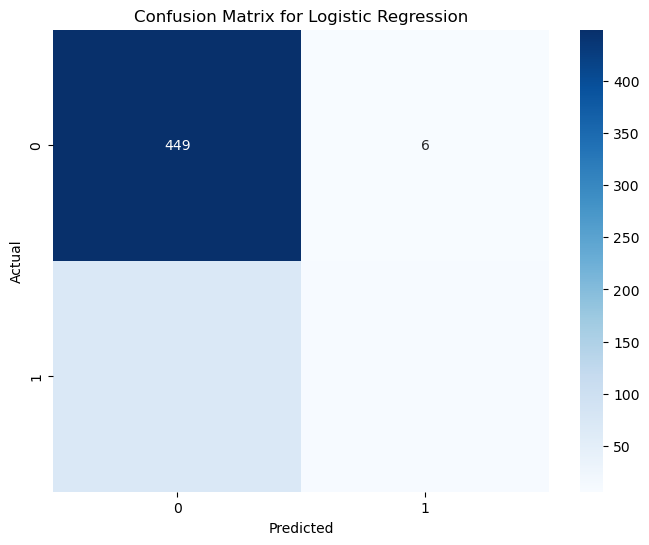


Details:
True Negatives (Not Churn, Not Churn): 449
False Positives (Not Churn, Churn): 6
False Negatives (Churn, Not Churn): 71
True Positives (Churn, Churn): 8


In [12]:
# Logistische Regression
log_reg = LogisticRegression(max_iter=2000, solver='lbfgs')

# Cross-Validation
cv_results = cross_validate(log_reg, X_train, y_train, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1'])

print(f"Logistic Regression Cross-Validation Accuracy: {np.mean(cv_results['test_accuracy']):.4f}")
print(f"Logistic Regression Cross-Validation Precision: {np.mean(cv_results['test_precision']):.4f}")
print(f"Logistic Regression Cross-Validation Recall: {np.mean(cv_results['test_recall']):.4f}")
print(f"Logistic Regression Cross-Validation F1 Score: {np.mean(cv_results['test_f1']):.4f}")

# Training
log_reg.fit(X_train, y_train)

# Vorhersagen
y_pred = log_reg.predict(X_test)

# Performance-Metriken
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"\nLogistic Regression Test Accuracy: {accuracy:.4f}")
print(f"Logistic Regression Test Precision: {precision:.4f}")
print(f"Logistic Regression Test Recall: {recall:.4f}")
print(f"Logistic Regression Test F1 Score: {f1:.4f}")
print(classification_report(y_test, y_pred))

# Konfusionsmatrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("\nDetails:")
print(f"True Negatives (Not Churn, Not Churn): {conf_matrix[0, 0]}")
print(f"False Positives (Not Churn, Churn): {conf_matrix[0, 1]}")
print(f"False Negatives (Churn, Not Churn): {conf_matrix[1, 0]}")
print(f"True Positives (Churn, Churn): {conf_matrix[1, 1]}")

Logistic Regression Cross-Validation Accuracy: 0.8710
Logistic Regression Cross-Validation Precision: 0.6363
Logistic Regression Cross-Validation Recall: 0.2848
Logistic Regression Cross-Validation F1 Score: 0.3916

Logistic Regression Test Accuracy: 0.8708
Logistic Regression Test Precision: 0.6316
Logistic Regression Test Recall: 0.3038
Logistic Regression Test F1 Score: 0.4103
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       455
           1       0.63      0.30      0.41        79

    accuracy                           0.87       534
   macro avg       0.76      0.64      0.67       534
weighted avg       0.85      0.87      0.85       534



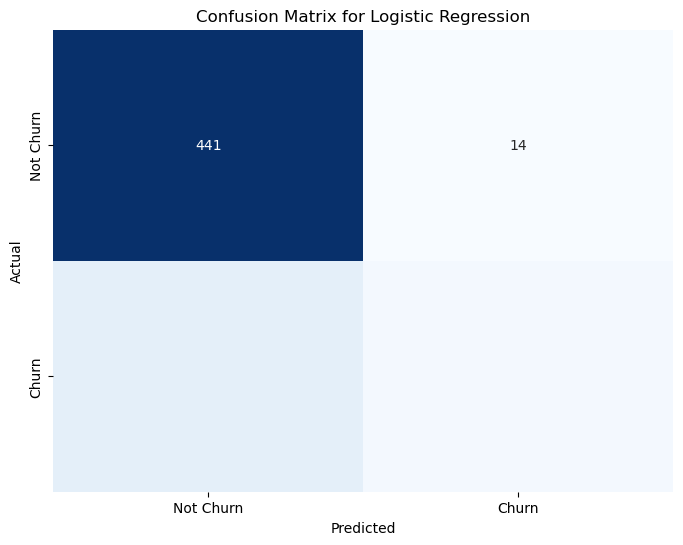


Details:
True Negatives (Not Churn, Not Churn): 441
False Positives (Not Churn, Churn): 14
False Negatives (Churn, Not Churn): 55
True Positives (Churn, Churn): 24


In [13]:
# Feature- und Zielvariablen
X = merged_df.drop(['Churn', 'State'], axis=1)
y = merged_df['Churn']

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Daten skalieren
scaler = StandardScaler()
Xsc_train = scaler.fit_transform(X_train)
Xsc_test = scaler.transform(X_test)

# Logistische Regression
log_reg = LogisticRegression(max_iter=2000, solver='lbfgs')

# Cross-Validation
cv_results = cross_validate(log_reg, Xsc_train, y_train, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1'])

print(f"Logistic Regression Cross-Validation Accuracy: {np.mean(cv_results['test_accuracy']):.4f}")
print(f"Logistic Regression Cross-Validation Precision: {np.mean(cv_results['test_precision']):.4f}")
print(f"Logistic Regression Cross-Validation Recall: {np.mean(cv_results['test_recall']):.4f}")
print(f"Logistic Regression Cross-Validation F1 Score: {np.mean(cv_results['test_f1']):.4f}")

# Training
log_reg.fit(Xsc_train, y_train)

# Vorhersagen
y_pred = log_reg.predict(Xsc_test)

# Performance-Metriken
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"\nLogistic Regression Test Accuracy: {accuracy:.4f}")
print(f"Logistic Regression Test Precision: {precision:.4f}")
print(f"Logistic Regression Test Recall: {recall:.4f}")
print(f"Logistic Regression Test F1 Score: {f1:.4f}")
print(classification_report(y_test, y_pred))

# Konfusionsmatrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Sicherstellen, dass alle Felder in der Konfusionsmatrix korrekt angezeigt werden
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


print("\nDetails:")
print(f"True Negatives (Not Churn, Not Churn): {conf_matrix[0, 0]}")
print(f"False Positives (Not Churn, Churn): {conf_matrix[0, 1]}")
print(f"False Negatives (Churn, Not Churn): {conf_matrix[1, 0]}")
print(f"True Positives (Churn, Churn): {conf_matrix[1, 1]}")

Cross Validation Scores:
Mean Accuracy: 0.9747
Mean Precision: 0.9962
Mean Recall: 0.8286
Mean F1 Score: 0.9041

Random Forest Test Accuracy: 0.9682
Random Forest Test Precision: 1.0000
Random Forest Test Recall: 0.7848
Random Forest Test F1 Score: 0.8794
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       455
           1       1.00      0.78      0.88        79

    accuracy                           0.97       534
   macro avg       0.98      0.89      0.93       534
weighted avg       0.97      0.97      0.97       534



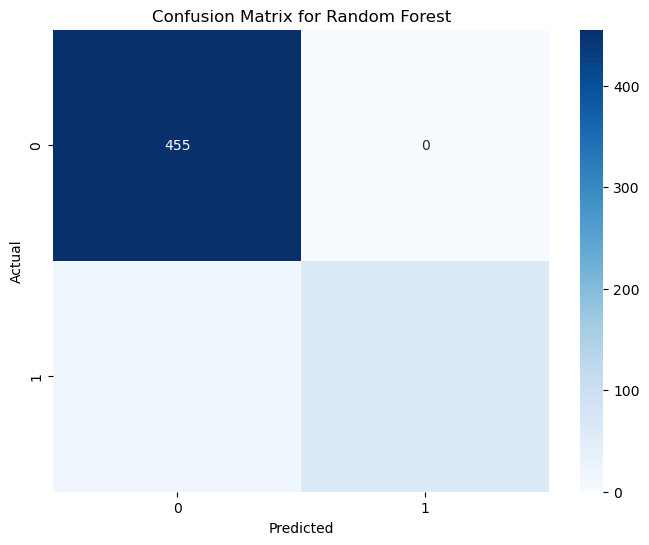


Details:
True Negatives (Not Churn, Not Churn): 455
False Positives (Not Churn, Churn): 0
False Negatives (Churn, Not Churn): 17
True Positives (Churn, Churn): 62


In [14]:
# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Cross-Validation
cv_scores_accuracy = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
cv_scores_precision = cross_val_score(rf, X_train, y_train, cv=5, scoring='precision')
cv_scores_recall = cross_val_score(rf, X_train, y_train, cv=5, scoring='recall')
cv_scores_f1 = cross_val_score(rf, X_train, y_train, cv=5, scoring='f1')

print("Cross Validation Scores:")
print(f"Mean Accuracy: {cv_scores_accuracy.mean():.4f}")
print(f"Mean Precision: {cv_scores_precision.mean():.4f}")
print(f"Mean Recall: {cv_scores_recall.mean():.4f}")
print(f"Mean F1 Score: {cv_scores_f1.mean():.4f}")

# Training
rf.fit(X_train, y_train)

# Vorhersagen
y_pred = rf.predict(X_test)

# Performance-Metriken
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"\nRandom Forest Test Accuracy: {accuracy:.4f}")
print(f"Random Forest Test Precision: {precision:.4f}")
print(f"Random Forest Test Recall: {recall:.4f}")
print(f"Random Forest Test F1 Score: {f1:.4f}")
print(classification_report(y_test, y_pred))

# Konfusionsmatrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("\nDetails:")
print(f"True Negatives (Not Churn, Not Churn): {conf_matrix[0, 0]}")
print(f"False Positives (Not Churn, Churn): {conf_matrix[0, 1]}")
print(f"False Negatives (Churn, Not Churn): {conf_matrix[1, 0]}")
print(f"True Positives (Churn, Churn): {conf_matrix[1, 1]}")

## Fine tuning Random Forest

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Beste Hyperparameter:  {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Random Forest (best) Test Accuracy: 0.9719
Random Forest (best) Test Precision: 1.0000
Random Forest (best) Test Recall: 0.8101
Random Forest (best) Test F1 Score: 0.8951
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       455
           1       1.00      0.81      0.90        79

    accuracy                           0.97       534
   macro avg       0.98      0.91      0.94       534
weighted avg       0.97      0.97      0.97       534



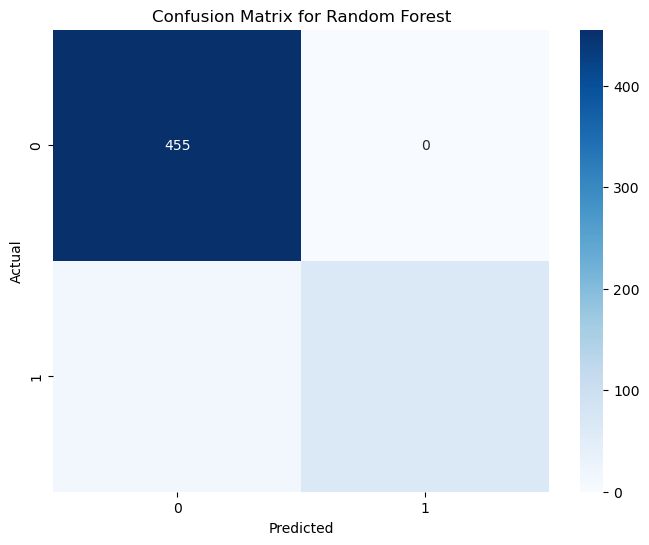


Details:
True Negatives (Not Churn, Not Churn): 455
False Positives (Not Churn, Churn): 0
False Negatives (Churn, Not Churn): 15
True Positives (Churn, Churn): 64


In [15]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter-Raster für Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# GridSearchCV Initialisierung
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Training mit GridSearchCV
grid_search.fit(X_train, y_train)

# Beste Hyperparameter
print("Beste Hyperparameter: ", grid_search.best_params_)

# Vorhersagen mit dem besten Modell
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test)

# Performance-Metriken
accuracy = accuracy_score(y_test, y_pred_best)
precision = precision_score(y_test, y_pred_best)
recall = recall_score(y_test, y_pred_best)
f1 = f1_score(y_test, y_pred_best)

print(f"Random Forest (best) Test Accuracy: {accuracy:.4f}")
print(f"Random Forest (best) Test Precision: {precision:.4f}")
print(f"Random Forest (best) Test Recall: {recall:.4f}")
print(f"Random Forest (best) Test F1 Score: {f1:.4f}")
print(classification_report(y_test, y_pred_best))

conf_matrix = confusion_matrix(y_test, y_pred_best)

# Konfusionsmatrix
conf_matrix = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("\nDetails:")
print(f"True Negatives (Not Churn, Not Churn): {conf_matrix[0, 0]}")
print(f"False Positives (Not Churn, Churn): {conf_matrix[0, 1]}")
print(f"False Negatives (Churn, Not Churn): {conf_matrix[1, 0]}")
print(f"True Positives (Churn, Churn): {conf_matrix[1, 1]}")

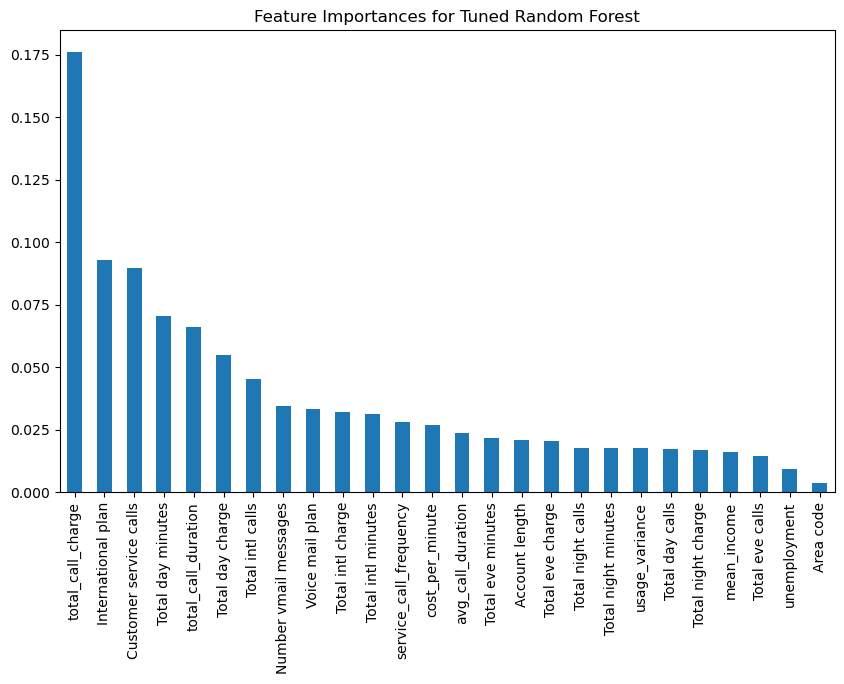

In [16]:
# Feature-Importance-Analyse für den getunten Random Forest
importances = grid_search.best_estimator_.feature_importances_
feature_names = X_train.columns
feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar')
plt.title('Feature Importances for Tuned Random Forest')
plt.show()


Cross Validation Scores:
Mean Accuracy: 0.9760
Mean Precision: 1.0000
Mean Recall: 0.8350
Mean F1 Score: 0.9094

Random Forest (reduced) Test Accuracy: 0.9700
Random Forest (reduced) Test Precision: 1.0000
Random Forest (reduced) Test Recall: 0.7975
Random Forest (reduced) Test F1 Score: 0.8873
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       455
           1       1.00      0.80      0.89        79

    accuracy                           0.97       534
   macro avg       0.98      0.90      0.94       534
weighted avg       0.97      0.97      0.97       534



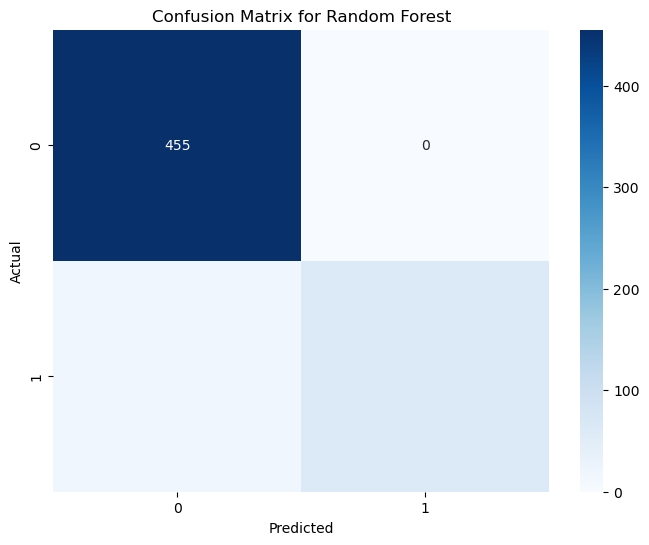


Details:
True Negatives (Not Churn, Not Churn): 455
False Positives (Not Churn, Churn): 0
False Negatives (Churn, Not Churn): 16
True Positives (Churn, Churn): 63


In [17]:
# Auswahl der wichtigsten Features basierend auf der Feature-Importance
important_features = ['total_call_charge', 'International plan', 'Customer service calls', 
                      'Total day minutes', 'total_call_duration', 'Total day charge', 
                      'Total intl calls', 'Number vmail messages', 'Voice mail plan', 
                      'Total intl charge', 'Total intl minutes', 'service_call_frequency', 
                      'cost_per_minute', 'avg_call_duration']

# Erstellen eines neuen DataFrames nur mit den wichtigsten Features
X_reduced = merged_df[important_features]
y = merged_df['Churn']

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Verwenden der besten Hyperparameter, die durch GridSearchCV gefunden wurden
best_params = {
    'bootstrap': True,
    'max_depth': None,
    'min_samples_leaf': 1,
    'min_samples_split': 5,
    'n_estimators': 100
}

# Random Forest mit den besten Hyperparametern und reduzierten Features
rf_reduced = RandomForestClassifier(**best_params, random_state=42)

# Kreuzvalidierungsscores
cv_scores_accuracy = cross_val_score(rf_reduced, X_reduced, y, cv=5, scoring='accuracy')
cv_scores_precision = cross_val_score(rf_reduced, X_reduced, y, cv=5, scoring='precision')
cv_scores_recall = cross_val_score(rf_reduced, X_reduced, y, cv=5, scoring='recall')
cv_scores_f1 = cross_val_score(rf_reduced, X_reduced, y, cv=5, scoring='f1')

print("Cross Validation Scores:")
print(f"Mean Accuracy: {cv_scores_accuracy.mean():.4f}")
print(f"Mean Precision: {cv_scores_precision.mean():.4f}")
print(f"Mean Recall: {cv_scores_recall.mean():.4f}")
print(f"Mean F1 Score: {cv_scores_f1.mean():.4f}")

# Training mit den reduzierten Features und besten Hyperparametern
rf_reduced.fit(X_train, y_train)

# Vorhersagen mit dem reduzierten Modell
y_pred_reduced = rf_reduced.predict(X_test)

# Performance-Metriken für das reduzierte Modell
accuracy = accuracy_score(y_test, y_pred_reduced)
precision = precision_score(y_test, y_pred_reduced)
recall = recall_score(y_test, y_pred_reduced)
f1 = f1_score(y_test, y_pred_reduced)

print(f"\nRandom Forest (reduced) Test Accuracy: {accuracy:.4f}")
print(f"Random Forest (reduced) Test Precision: {precision:.4f}")
print(f"Random Forest (reduced) Test Recall: {recall:.4f}")
print(f"Random Forest (reduced) Test F1 Score: {f1:.4f}")
print(classification_report(y_test, y_pred_reduced))

# Konfusionsmatrix
conf_matrix = confusion_matrix(y_test, y_pred_reduced)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("\nDetails:")
print(f"True Negatives (Not Churn, Not Churn): {conf_matrix[0, 0]}")
print(f"False Positives (Not Churn, Churn): {conf_matrix[0, 1]}")
print(f"False Negatives (Churn, Not Churn): {conf_matrix[1, 0]}")
print(f"True Positives (Churn, Churn): {conf_matrix[1, 1]}")

Cross Validation Scores:
Mean Accuracy: 0.9760
Mean Precision: 1.0000
Mean Recall: 0.8350
Mean F1 Score: 0.9094

Random Forest (reduced) Test Accuracy: 0.9700
Random Forest (reduced) Test Precision: 1.0000
Random Forest (reduced) Test Recall: 0.7975
Random Forest (reduced) Test F1 Score: 0.8873
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       455
           1       1.00      0.80      0.89        79

    accuracy                           0.97       534
   macro avg       0.98      0.90      0.94       534
weighted avg       0.97      0.97      0.97       534



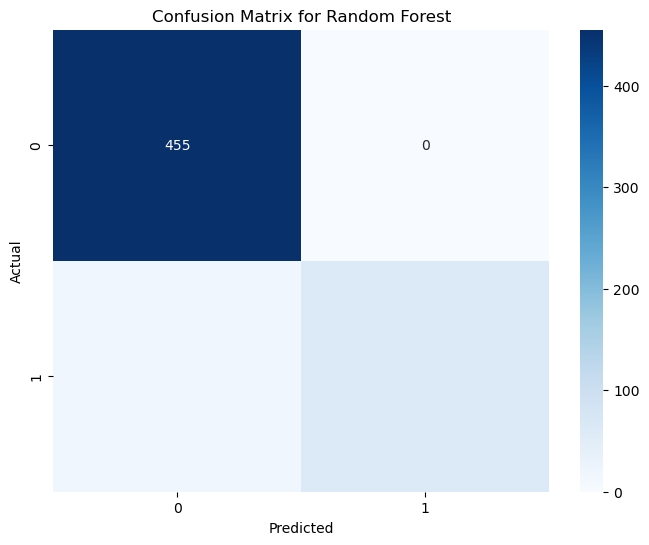


Details:
True Negatives (Not Churn, Not Churn): 455
False Positives (Not Churn, Churn): 0
False Negatives (Churn, Not Churn): 16
True Positives (Churn, Churn): 63

Feature Importances for the reduced model:
Feature: total_call_charge, Importance: 0.2263
Feature: Customer service calls, Importance: 0.1022
Feature: International plan, Importance: 0.0995
Feature: Total day charge, Importance: 0.0757
Feature: total_call_duration, Importance: 0.0757
Feature: Total day minutes, Importance: 0.0672
Feature: Total intl calls, Importance: 0.0586
Feature: Number vmail messages, Importance: 0.0490
Feature: Total intl charge, Importance: 0.0451
Feature: Total intl minutes, Importance: 0.0446
Feature: avg_call_duration, Importance: 0.0414
Feature: service_call_frequency, Importance: 0.0409
Feature: cost_per_minute, Importance: 0.0401
Feature: Voice mail plan, Importance: 0.0337


In [18]:
from sklearn.model_selection import cross_val_score

# Auswahl der wichtigsten Features basierend auf der weiteren Reduktion
important_features_reduced = ['total_call_charge', 'International plan', 'Customer service calls', 
                      'Total day minutes', 'total_call_duration', 'Total day charge', 
                      'Total intl calls', 'Number vmail messages', 
                      'Total intl charge', 'Total intl minutes', 
                      'cost_per_minute', 'avg_call_duration']

# Erstellen eines neuen DataFrames nur mit den wichtigsten Features
X_reduced = merged_df[important_features]
y = merged_df['Churn']

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Verwenden der besten Hyperparameter, die durch GridSearchCV gefunden wurden
best_params = {
    'bootstrap': True,
    'max_depth': None,
    'min_samples_leaf': 1,
    'min_samples_split': 5,
    'n_estimators': 100
}

# Random Forest mit den besten Hyperparametern und reduzierten Features
rf_reduced = RandomForestClassifier(**best_params, random_state=42)

# Kreuzvalidierungsscores
cv_scores_accuracy = cross_val_score(rf_reduced, X_reduced, y, cv=5, scoring='accuracy')
cv_scores_precision = cross_val_score(rf_reduced, X_reduced, y, cv=5, scoring='precision')
cv_scores_recall = cross_val_score(rf_reduced, X_reduced, y, cv=5, scoring='recall')
cv_scores_f1 = cross_val_score(rf_reduced, X_reduced, y, cv=5, scoring='f1')

print("Cross Validation Scores:")
print(f"Mean Accuracy: {cv_scores_accuracy.mean():.4f}")
print(f"Mean Precision: {cv_scores_precision.mean():.4f}")
print(f"Mean Recall: {cv_scores_recall.mean():.4f}")
print(f"Mean F1 Score: {cv_scores_f1.mean():.4f}")

# Training mit den reduzierten Features und besten Hyperparametern
rf_reduced.fit(X_train, y_train)

# Vorhersagen mit dem reduzierten Modell
y_pred_reduced = rf_reduced.predict(X_test)

# Performance-Metriken für das reduzierte Modell
accuracy = accuracy_score(y_test, y_pred_reduced)
precision = precision_score(y_test, y_pred_reduced)
recall = recall_score(y_test, y_pred_reduced)
f1 = f1_score(y_test, y_pred_reduced)

print(f"\nRandom Forest (reduced) Test Accuracy: {accuracy:.4f}")
print(f"Random Forest (reduced) Test Precision: {precision:.4f}")
print(f"Random Forest (reduced) Test Recall: {recall:.4f}")
print(f"Random Forest (reduced) Test F1 Score: {f1:.4f}")
print(classification_report(y_test, y_pred_reduced))

# Konfusionsmatrix
conf_matrix = confusion_matrix(y_test, y_pred_reduced)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("\nDetails:")
print(f"True Negatives (Not Churn, Not Churn): {conf_matrix[0, 0]}")
print(f"False Positives (Not Churn, Churn): {conf_matrix[0, 1]}")
print(f"False Negatives (Churn, Not Churn): {conf_matrix[1, 0]}")
print(f"True Positives (Churn, Churn): {conf_matrix[1, 1]}")

# Feature-Importance-Analyse für das reduzierte Modell
importances_reduced = rf_reduced.feature_importances_
feature_importances_reduced = pd.Series(importances_reduced, index=important_features).sort_values(ascending=False)

print("\nFeature Importances for the reduced model:")
for feature, importance in feature_importances_reduced.items():
    print(f"Feature: {feature}, Importance: {importance:.4f}")


# Save Model

In [19]:
import pickle

# save model to file
model_filename = "RandomForestClassification.pkl"
with open(model_filename, mode="bw") as f:
    pickle.dump(rf_reduced, file=f)

## Error Analysis

Misclassified records:
      total_call_charge  International plan  Customer service calls  \
1029              39.57                   0                       1   
2039              67.77                   0                       2   
2306              49.44                   0                       2   
324               59.48                   0                       1   
1918              50.70                   0                       1   
969               69.36                   0                       0   
321               66.91                   0                       0   
1560              67.21                   0                       1   
435               77.68                   1                       9   
1381              63.06                   0                       1   
1783              56.63                   0                       5   
2114              90.12                   0                       1   
2111              66.37                   0           

C:\Users\dario\AppData\Local\Temp\ipykernel_65952\2885240887.py:25: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_test[X_test['Correctly_Classified'] == True][column], label='Correctly Classified', shade=True)
c:\Users\dario\anaconda3\envs\kia\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\dario\AppData\Local\Temp\ipykernel_65952\2885240887.py:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_test[X_test['Correctly_Classified'] == False][column], label='Misclassified', shade=True)
c:\Users\dario\anaconda3\envs\kia\lib\site-packages\seaborn

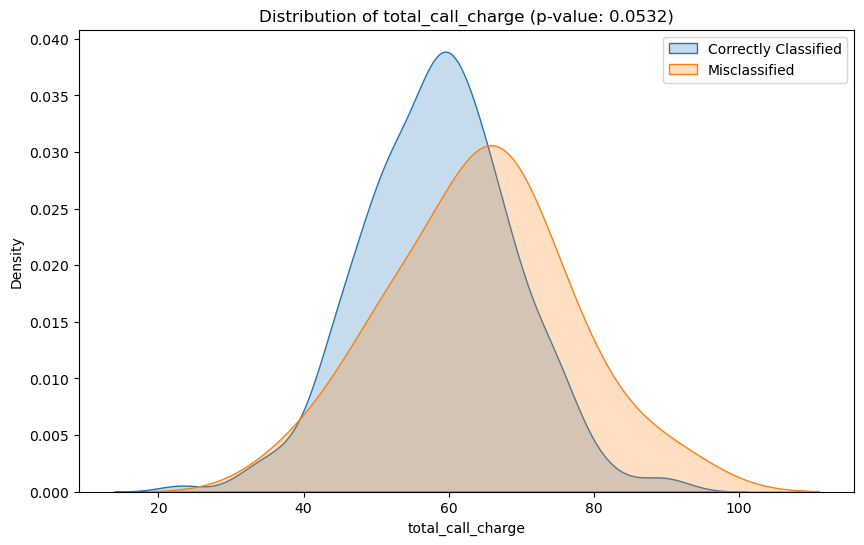

C:\Users\dario\AppData\Local\Temp\ipykernel_65952\2885240887.py:25: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_test[X_test['Correctly_Classified'] == True][column], label='Correctly Classified', shade=True)
c:\Users\dario\anaconda3\envs\kia\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\dario\AppData\Local\Temp\ipykernel_65952\2885240887.py:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_test[X_test['Correctly_Classified'] == False][column], label='Misclassified', shade=True)
c:\Users\dario\anaconda3\envs\kia\lib\site-packages\seaborn

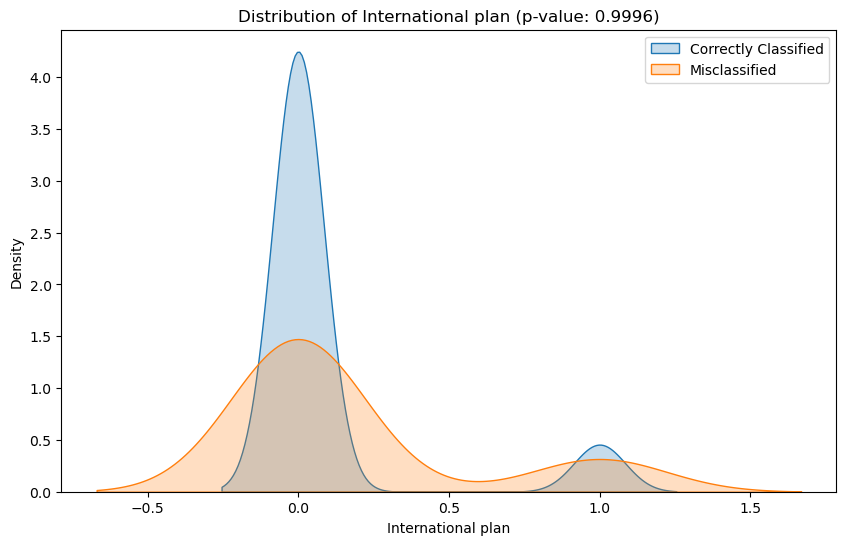

C:\Users\dario\AppData\Local\Temp\ipykernel_65952\2885240887.py:25: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_test[X_test['Correctly_Classified'] == True][column], label='Correctly Classified', shade=True)
c:\Users\dario\anaconda3\envs\kia\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\dario\AppData\Local\Temp\ipykernel_65952\2885240887.py:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_test[X_test['Correctly_Classified'] == False][column], label='Misclassified', shade=True)
c:\Users\dario\anaconda3\envs\kia\lib\site-packages\seaborn

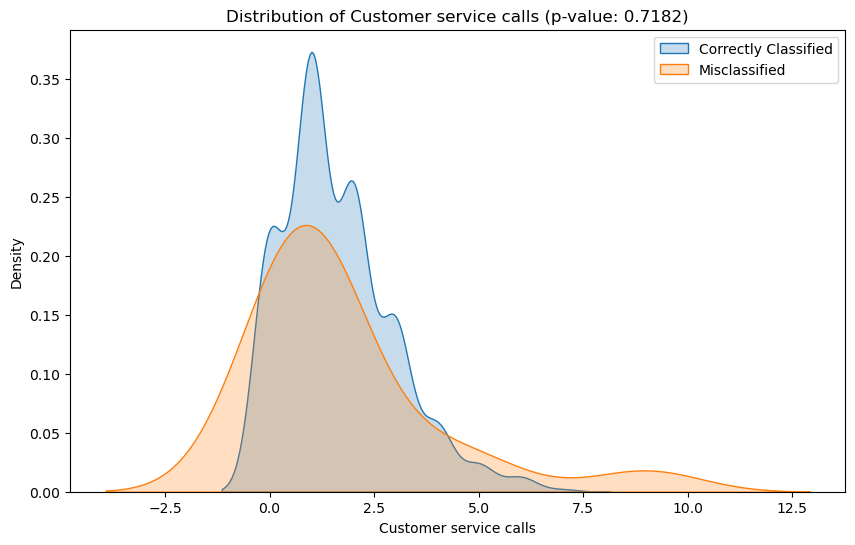

C:\Users\dario\AppData\Local\Temp\ipykernel_65952\2885240887.py:25: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_test[X_test['Correctly_Classified'] == True][column], label='Correctly Classified', shade=True)
c:\Users\dario\anaconda3\envs\kia\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\dario\AppData\Local\Temp\ipykernel_65952\2885240887.py:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_test[X_test['Correctly_Classified'] == False][column], label='Misclassified', shade=True)
c:\Users\dario\anaconda3\envs\kia\lib\site-packages\seaborn

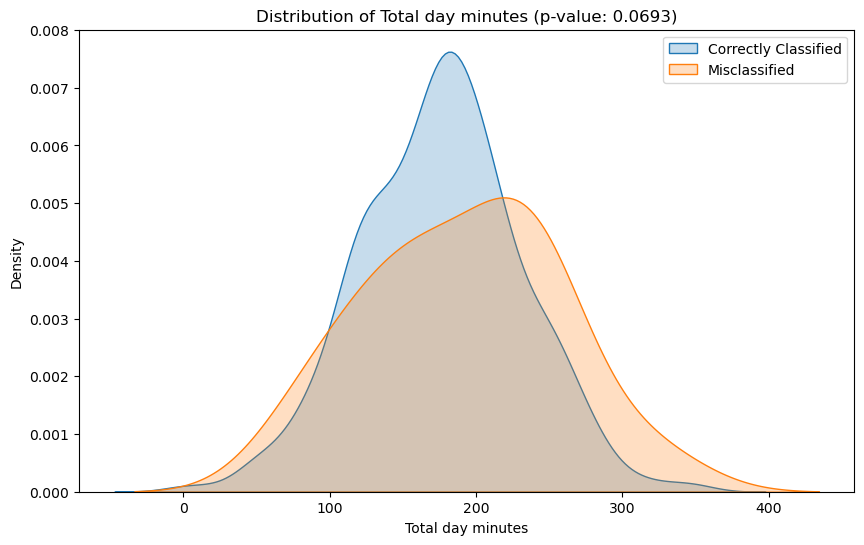

C:\Users\dario\AppData\Local\Temp\ipykernel_65952\2885240887.py:25: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_test[X_test['Correctly_Classified'] == True][column], label='Correctly Classified', shade=True)
c:\Users\dario\anaconda3\envs\kia\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\dario\AppData\Local\Temp\ipykernel_65952\2885240887.py:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_test[X_test['Correctly_Classified'] == False][column], label='Misclassified', shade=True)
c:\Users\dario\anaconda3\envs\kia\lib\site-packages\seaborn

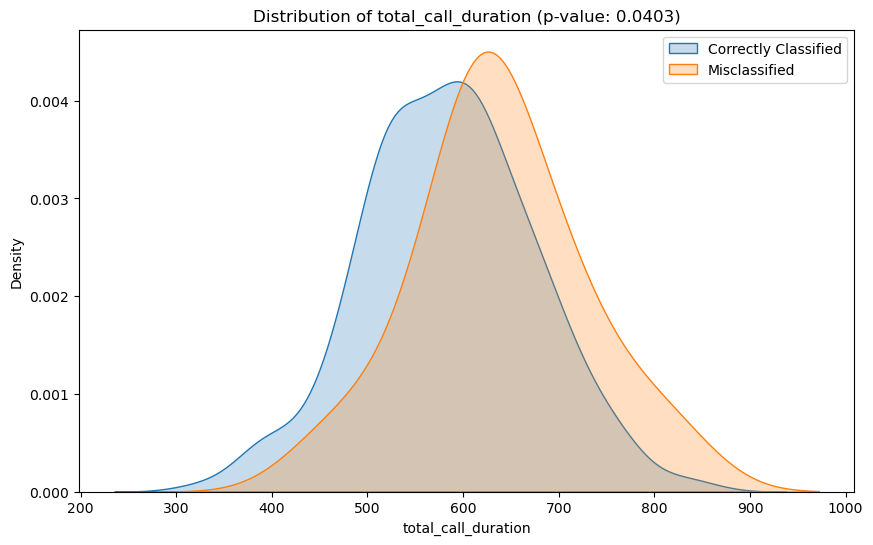

C:\Users\dario\AppData\Local\Temp\ipykernel_65952\2885240887.py:25: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_test[X_test['Correctly_Classified'] == True][column], label='Correctly Classified', shade=True)
c:\Users\dario\anaconda3\envs\kia\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\dario\AppData\Local\Temp\ipykernel_65952\2885240887.py:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_test[X_test['Correctly_Classified'] == False][column], label='Misclassified', shade=True)
c:\Users\dario\anaconda3\envs\kia\lib\site-packages\seaborn

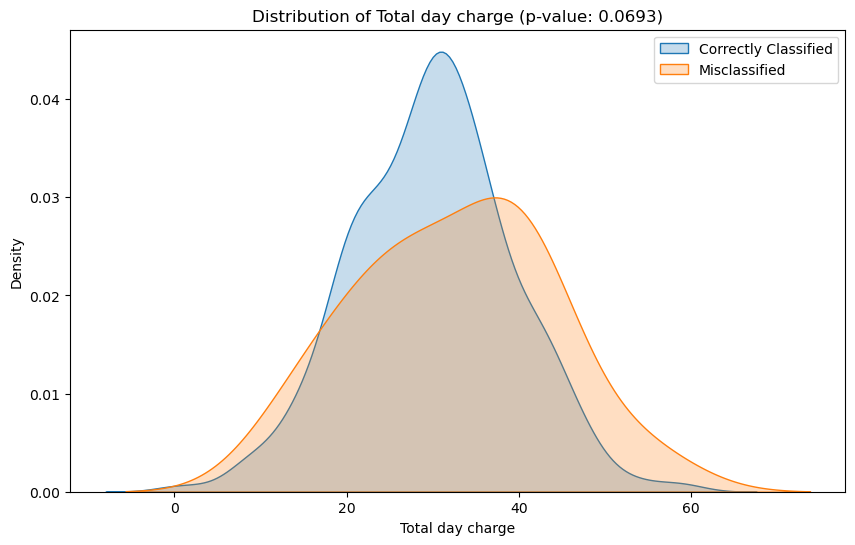

C:\Users\dario\AppData\Local\Temp\ipykernel_65952\2885240887.py:25: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_test[X_test['Correctly_Classified'] == True][column], label='Correctly Classified', shade=True)
c:\Users\dario\anaconda3\envs\kia\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\dario\AppData\Local\Temp\ipykernel_65952\2885240887.py:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_test[X_test['Correctly_Classified'] == False][column], label='Misclassified', shade=True)
c:\Users\dario\anaconda3\envs\kia\lib\site-packages\seaborn

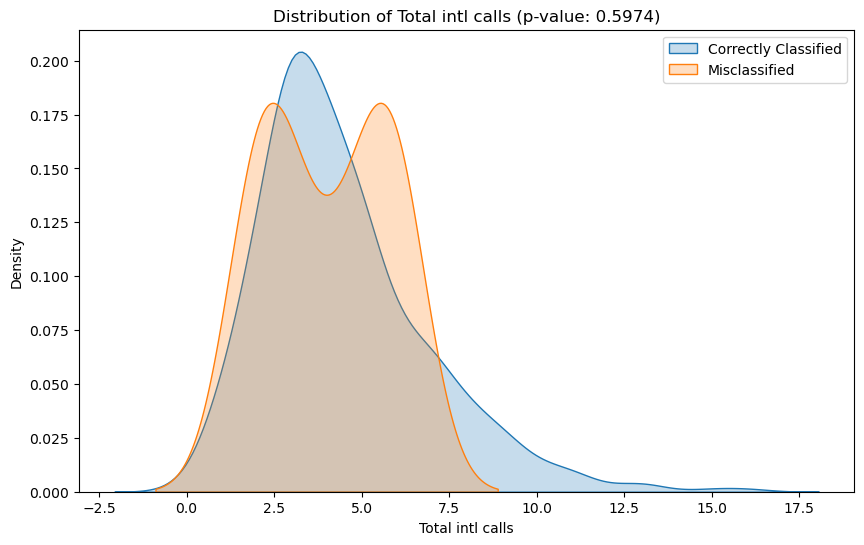

C:\Users\dario\AppData\Local\Temp\ipykernel_65952\2885240887.py:25: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_test[X_test['Correctly_Classified'] == True][column], label='Correctly Classified', shade=True)
c:\Users\dario\anaconda3\envs\kia\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\dario\AppData\Local\Temp\ipykernel_65952\2885240887.py:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_test[X_test['Correctly_Classified'] == False][column], label='Misclassified', shade=True)
c:\Users\dario\anaconda3\envs\kia\lib\site-packages\seaborn

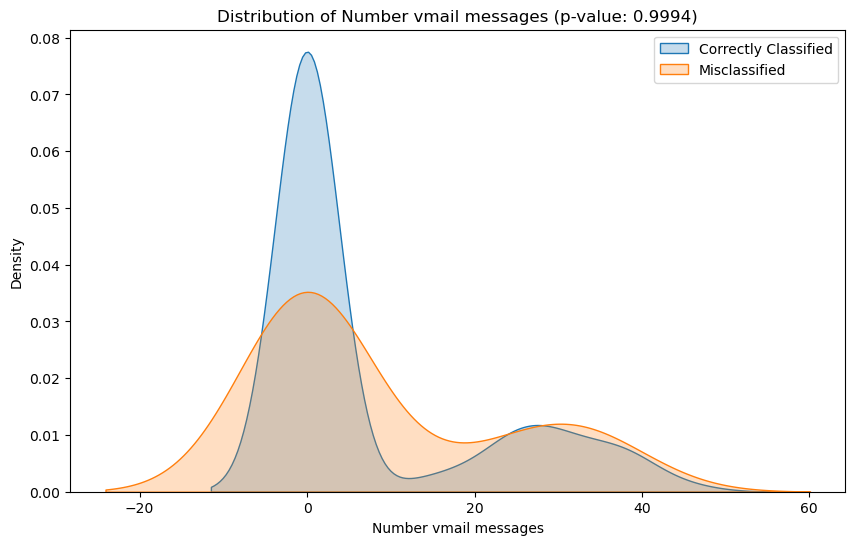

C:\Users\dario\AppData\Local\Temp\ipykernel_65952\2885240887.py:25: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_test[X_test['Correctly_Classified'] == True][column], label='Correctly Classified', shade=True)
c:\Users\dario\anaconda3\envs\kia\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\dario\AppData\Local\Temp\ipykernel_65952\2885240887.py:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_test[X_test['Correctly_Classified'] == False][column], label='Misclassified', shade=True)
c:\Users\dario\anaconda3\envs\kia\lib\site-packages\seaborn

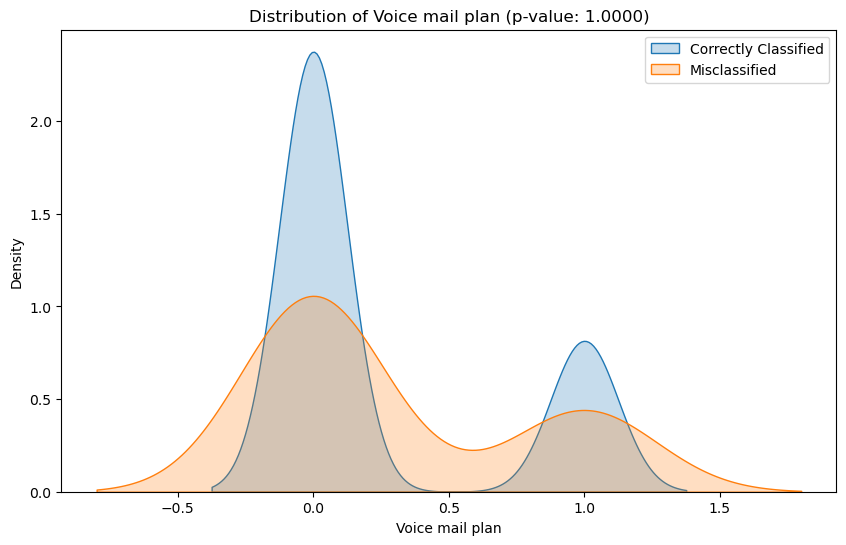

C:\Users\dario\AppData\Local\Temp\ipykernel_65952\2885240887.py:25: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_test[X_test['Correctly_Classified'] == True][column], label='Correctly Classified', shade=True)
c:\Users\dario\anaconda3\envs\kia\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\dario\AppData\Local\Temp\ipykernel_65952\2885240887.py:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_test[X_test['Correctly_Classified'] == False][column], label='Misclassified', shade=True)
c:\Users\dario\anaconda3\envs\kia\lib\site-packages\seaborn

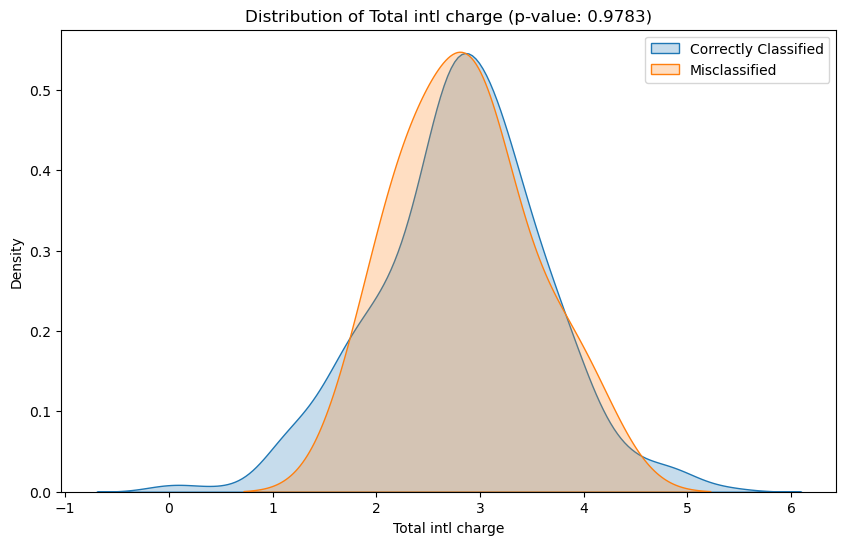

C:\Users\dario\AppData\Local\Temp\ipykernel_65952\2885240887.py:25: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_test[X_test['Correctly_Classified'] == True][column], label='Correctly Classified', shade=True)
c:\Users\dario\anaconda3\envs\kia\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\dario\AppData\Local\Temp\ipykernel_65952\2885240887.py:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_test[X_test['Correctly_Classified'] == False][column], label='Misclassified', shade=True)
c:\Users\dario\anaconda3\envs\kia\lib\site-packages\seaborn

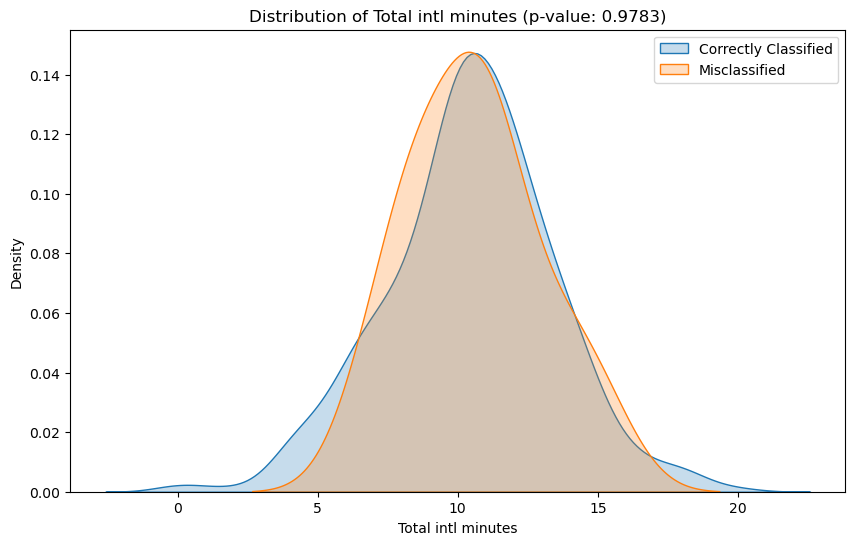

C:\Users\dario\AppData\Local\Temp\ipykernel_65952\2885240887.py:25: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_test[X_test['Correctly_Classified'] == True][column], label='Correctly Classified', shade=True)
c:\Users\dario\anaconda3\envs\kia\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\dario\AppData\Local\Temp\ipykernel_65952\2885240887.py:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_test[X_test['Correctly_Classified'] == False][column], label='Misclassified', shade=True)
c:\Users\dario\anaconda3\envs\kia\lib\site-packages\seaborn

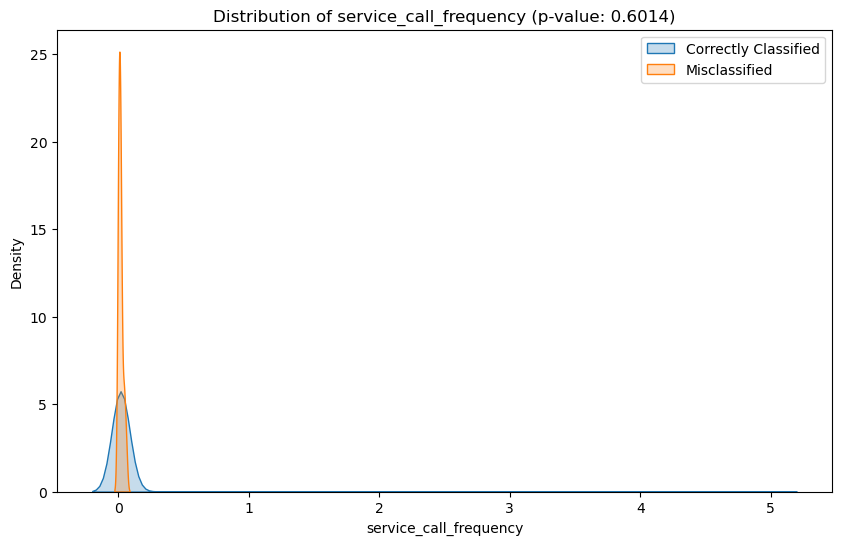

C:\Users\dario\AppData\Local\Temp\ipykernel_65952\2885240887.py:25: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_test[X_test['Correctly_Classified'] == True][column], label='Correctly Classified', shade=True)
c:\Users\dario\anaconda3\envs\kia\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\dario\AppData\Local\Temp\ipykernel_65952\2885240887.py:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_test[X_test['Correctly_Classified'] == False][column], label='Misclassified', shade=True)
c:\Users\dario\anaconda3\envs\kia\lib\site-packages\seaborn

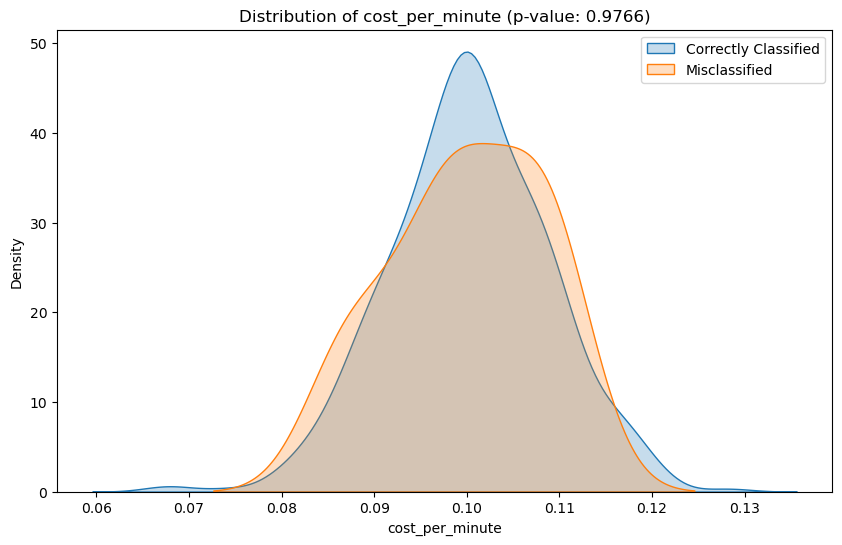

C:\Users\dario\AppData\Local\Temp\ipykernel_65952\2885240887.py:25: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_test[X_test['Correctly_Classified'] == True][column], label='Correctly Classified', shade=True)
c:\Users\dario\anaconda3\envs\kia\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\dario\AppData\Local\Temp\ipykernel_65952\2885240887.py:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_test[X_test['Correctly_Classified'] == False][column], label='Misclassified', shade=True)
c:\Users\dario\anaconda3\envs\kia\lib\site-packages\seaborn

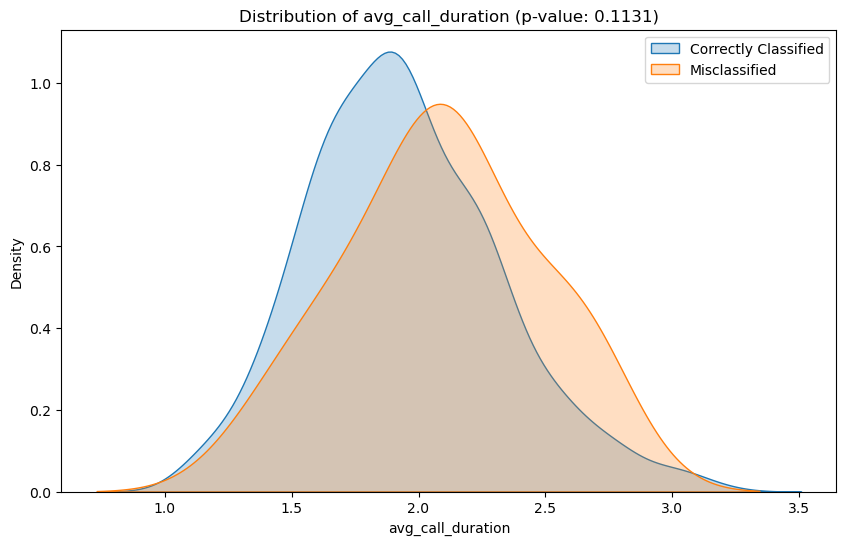


All columns where distributions were compared:
['total_call_charge', 'International plan', 'Customer service calls', 'Total day minutes', 'total_call_duration', 'Total day charge', 'Total intl calls', 'Number vmail messages', 'Voice mail plan', 'Total intl charge', 'Total intl minutes', 'service_call_frequency', 'cost_per_minute', 'avg_call_duration']


C:\Users\dario\AppData\Local\Temp\ipykernel_65952\2885240887.py:39: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_test[X_test['Correctly_Classified'] == True][column], label='Correctly Classified', shade=True)
c:\Users\dario\anaconda3\envs\kia\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\dario\AppData\Local\Temp\ipykernel_65952\2885240887.py:40: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_test[X_test['Correctly_Classified'] == False][column], label='Misclassified', shade=True)
c:\Users\dario\anaconda3\envs\kia\lib\site-packages\seaborn

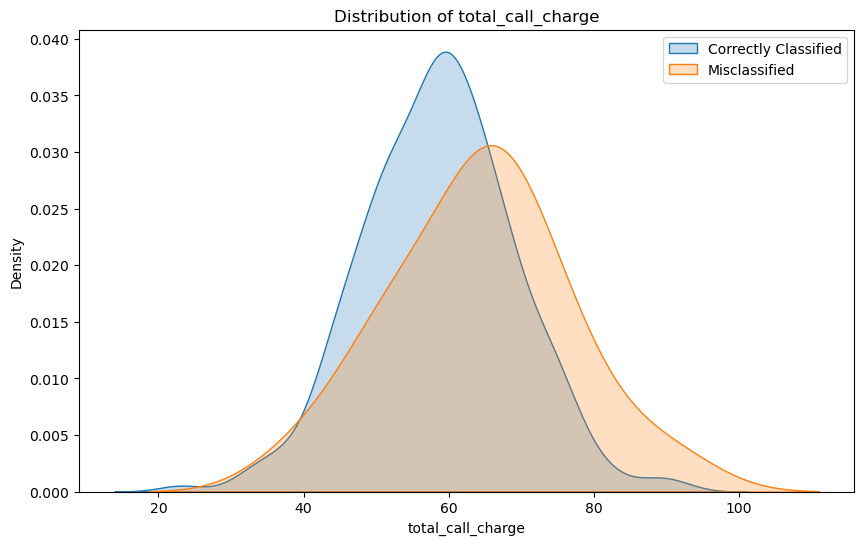

C:\Users\dario\AppData\Local\Temp\ipykernel_65952\2885240887.py:39: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_test[X_test['Correctly_Classified'] == True][column], label='Correctly Classified', shade=True)
c:\Users\dario\anaconda3\envs\kia\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\dario\AppData\Local\Temp\ipykernel_65952\2885240887.py:40: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_test[X_test['Correctly_Classified'] == False][column], label='Misclassified', shade=True)
c:\Users\dario\anaconda3\envs\kia\lib\site-packages\seaborn

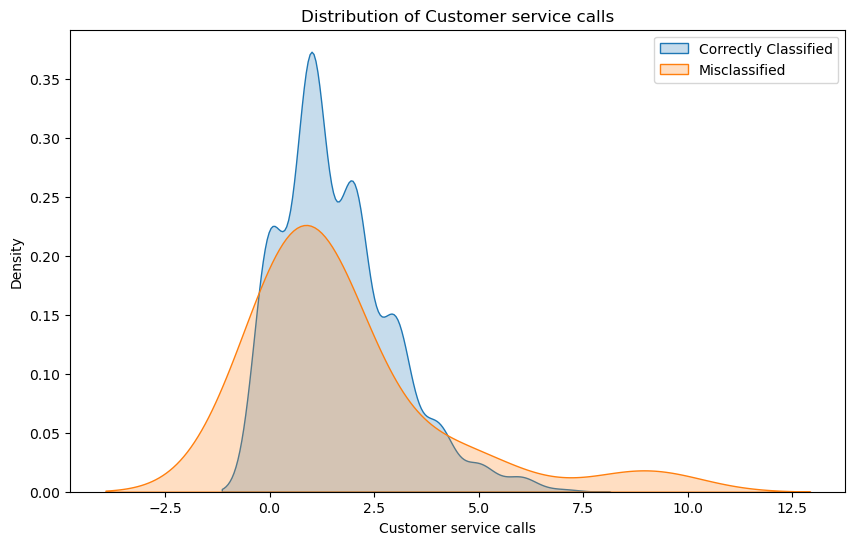

C:\Users\dario\AppData\Local\Temp\ipykernel_65952\2885240887.py:39: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_test[X_test['Correctly_Classified'] == True][column], label='Correctly Classified', shade=True)
c:\Users\dario\anaconda3\envs\kia\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\dario\AppData\Local\Temp\ipykernel_65952\2885240887.py:40: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_test[X_test['Correctly_Classified'] == False][column], label='Misclassified', shade=True)
c:\Users\dario\anaconda3\envs\kia\lib\site-packages\seaborn

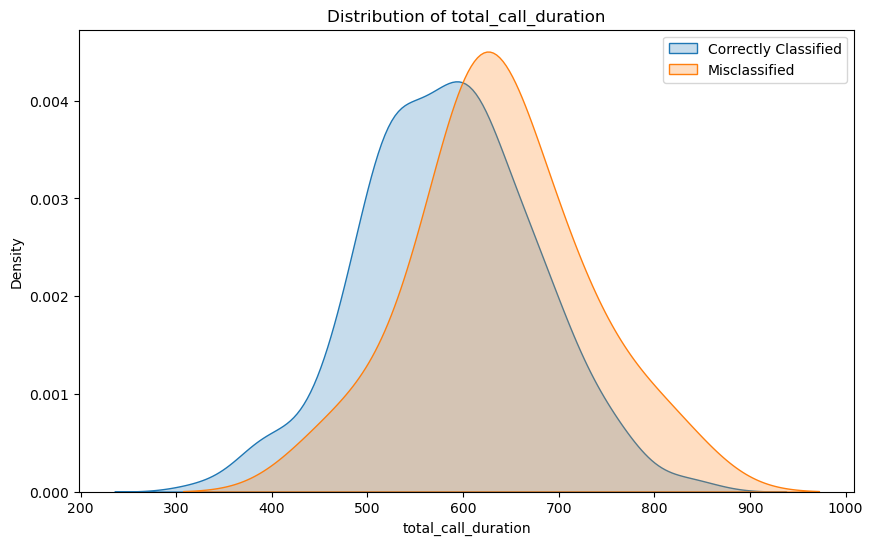

In [21]:
from scipy.stats import ks_2samp

# Falsch klassifizierte Datensätze kennzeichnen
X_test['Churn'] = y_test
X_test['Prediction'] = y_pred
X_test['Correctly_Classified'] = X_test['Churn'] == X_test['Prediction']

# Falsch klassifizierte Datensätze extrahieren
misclassified = X_test[X_test['Correctly_Classified'] == False]
print("Misclassified records:")
print(misclassified)

# Statistische Analyse
print("\nStatistical summary of misclassified records:")
print(misclassified.describe())

# Verteilungen vergleichen und alle anzeigen
all_columns = []
for column in X_test.columns:  # Verwende X_test.columns statt X.columns
    if column not in ['Churn', 'Prediction', 'Correctly_Classified']:  # Überspringe die hinzugefügten Spalten
        stat, p_value = ks_2samp(X_test[X_test['Correctly_Classified'] == True][column],
                                 X_test[X_test['Correctly_Classified'] == False][column])
        all_columns.append(column)
        plt.figure(figsize=(10, 6))
        sns.kdeplot(X_test[X_test['Correctly_Classified'] == True][column], label='Correctly Classified', shade=True)
        sns.kdeplot(X_test[X_test['Correctly_Classified'] == False][column], label='Misclassified', shade=True)
        plt.title(f'Distribution of {column} (p-value: {p_value:.4f})')
        plt.legend()
        plt.show()

print("\nAll columns where distributions were compared:")
print(all_columns)

# Verteilungen vergleichen für spezifische Werte
columns_to_compare = ['total_call_charge', 'Customer service calls', 'total_call_duration']

for column in columns_to_compare:
    plt.figure(figsize=(10, 6))
    sns.kdeplot(X_test[X_test['Correctly_Classified'] == True][column], label='Correctly Classified', shade=True)
    sns.kdeplot(X_test[X_test['Correctly_Classified'] == False][column], label='Misclassified', shade=True)
    plt.title(f'Distribution of {column}')
    plt.legend()
    plt.show()



## User Validation

Some quite logical tendencies can be observed in the operational use of the Predictor.

Generally speaking, customer loyalty is highest among customers who make heavy use of their subscription; somewhat surprisingly, the cost component is the most important factor.

Many contacts with customer service tend to be negative and customers with an international plan are more difficult to retain than those without one. 
